In [1]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")
# !apt-get remove python3-blinker
#!pip install --upgrade pip
#!pip install mlflow




# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [2]:

import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import numpy as np

# Hugging Face dataset loading
from datasets import load_dataset

######################################
# 1. CONFIGURE THE MLflow TRACKING URI
######################################

# Adjust the address for your MLflow server if necessary.
# For example, if you run Docker on localhost, it might be http://127.0.0.1:5000
# or if your Docker is on a remote server, you'll replace "127.0.0.1" with that address or domain.
mlflow.set_tracking_uri("http://192.168.1.44:5000")  # or http://YOUR_SERVER:5000

# Set an experiment name (will be created if it doesn't exist).
EXPERIMENT_NAME = "resnet_alien_vs_predator"
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='mlflow-artifacts:/560886446224533338', creation_time=1741750510905, experiment_id='560886446224533338', last_update_time=1741750510905, lifecycle_stage='active', name='resnet_alien_vs_predator', tags={}>

# 2. LOAD DATASET FROM HUGGING FACE

In [3]:

######################################
# 2. LOAD DATASET FROM HUGGING FACE
######################################

# This dataset is from Hugging Face, consisting of "alien" vs "predator" images
dataset = load_dataset("WriLee/alient_predator")

# The dataset has splits: train, test
# Let's see what columns we have:
print("Train dataset:", dataset["train"])
print("Test dataset:", dataset["validation"])

Train dataset: Dataset({
    features: ['image', 'label'],
    num_rows: 694
})
Test dataset: Dataset({
    features: ['image', 'label'],
    num_rows: 200
})


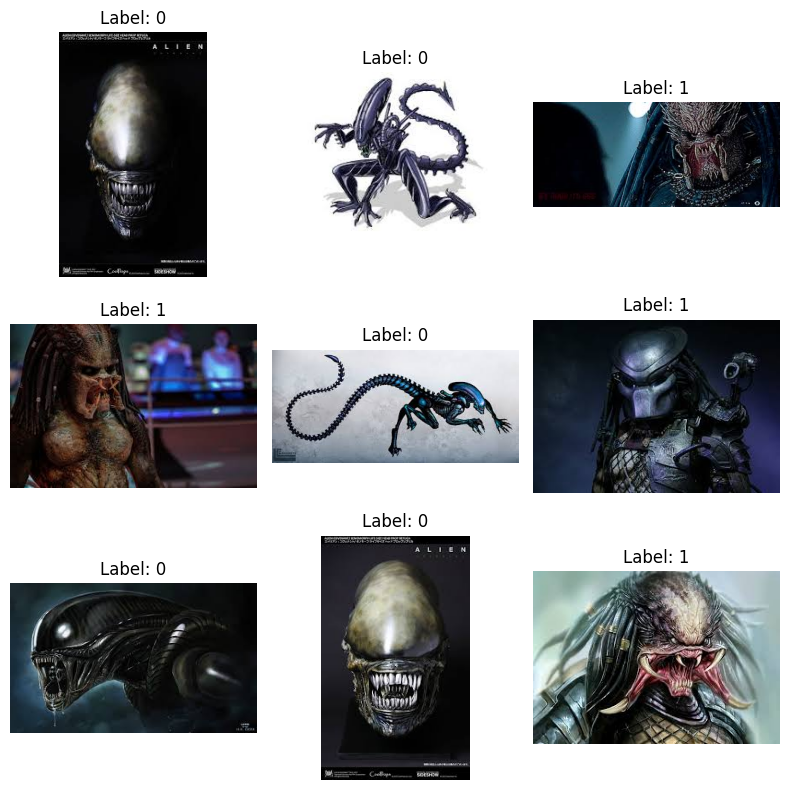

In [4]:
import random
import matplotlib.pyplot as plt

#2. Randomly select 9 indices from the training set
random_indices = random.sample(range(len(dataset["train"])), 9)

# 3. Create a 3x3 figure
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

for i, idx in enumerate(random_indices):
    row = i // 3
    col = i % 3

    sample = dataset["train"][idx]
    image = sample["image"]
    label = sample["label"]

    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

# 3. PREPARE DATASETS & DATALOADERS



In [5]:

import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import numpy as np

######################################
# 3. PREPARE DATASETS & DATALOADERS
######################################
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Force 3-channel
    transforms.ToTensor()
])

def transform_fn(example):
    # Ensure the image is transformed into a tensor
    example["pixel_values"] = transform(example["image"])
    return example

# Apply transform to each split (assuming 'dataset' is a Hugging Face dataset)
# Note: 'dataset' should be defined before this point; assuming it's available
train_dataset = dataset["train"].map(transform_fn)
test_dataset = dataset["validation"].map(transform_fn)


In [6]:

# Custom PyTorch Dataset wrapper
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        row = self.hf_dataset[idx]
        # If pixel_values is a list, convert it to a tensor
        x = row["pixel_values"]
        if isinstance(x, list):
            x = torch.tensor(x, dtype=torch.float32)  # Convert list to tensor
        # Ensure x is a tensor (this should already be true if transform worked)
        elif not isinstance(x, torch.Tensor):
            raise ValueError(f"pixel_values at index {idx} is not a tensor or list: {type(x)}")
        
        # Ensure label is a tensor
        y = torch.tensor(row["label"], dtype=torch.long)
        return x, y

train_torch_dataset = HFDataset(train_dataset)
test_torch_dataset = HFDataset(test_dataset)

# Create DataLoaders
train_loader = DataLoader(train_torch_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_torch_dataset, batch_size=8, shuffle=False)



In [7]:
from torchvision.models import ResNet18_Weights
######################################
# 4. CREATE RESNET MODEL
######################################

# We'll use a pretrained ResNet18 and fine-tune the last layer
resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
# Replace the final layer for 2 classes (alien vs predator)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)

In [8]:
#####################################
# 5. DEFINE TRAINING UTILS
######################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        # Ensure images and labels are tensors and move them to the device
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            # Ensure images and labels are tensors and move them to the device
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy


In [9]:

######################################
# 6. TRAIN AND LOG TO MLFLOW
######################################

# Start an MLflow run
with mlflow.start_run(run_name="resnet_training_run_a") as run:
    # Log some parameters
    mlflow.log_param("learning_rate", 1e-4)
    mlflow.log_param("batch_size", 8)
    mlflow.log_param("epochs", 2)  # we'll just train for 2 epochs for demonstration

    epochs = 10
    for epoch in range(epochs):
        train_loss = train_one_epoch(resnet, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(resnet, test_loader, criterion, device)

        # Log metrics for each epoch
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss",   val_loss,   step=epoch)
        mlflow.log_metric("val_acc",    val_acc,    step=epoch)
        
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Log the PyTorch model
    # Provide a registered_model_name to automatically register in Model Registry
    mlflow.pytorch.log_model(
        pytorch_model=resnet,
        artifact_path="model",
        registered_model_name="resnet_alien_vs_predator"
    )

    print(f"Run ID: {run.info.run_id}")

print("Training complete. Check the MLflow UI to see the run, metrics, and artifacts.")


Epoch [1/10] | Train Loss: 0.3433, Val Loss: 0.1525, Val Acc: 0.9400
Epoch [2/10] | Train Loss: 0.1185, Val Loss: 0.1780, Val Acc: 0.9200
Epoch [3/10] | Train Loss: 0.1572, Val Loss: 0.1512, Val Acc: 0.9450
Epoch [4/10] | Train Loss: 0.0946, Val Loss: 0.1013, Val Acc: 0.9550
Epoch [5/10] | Train Loss: 0.0826, Val Loss: 0.1440, Val Acc: 0.9400
Epoch [6/10] | Train Loss: 0.0566, Val Loss: 0.0993, Val Acc: 0.9500
Epoch [7/10] | Train Loss: 0.1024, Val Loss: 0.1508, Val Acc: 0.9150
Epoch [8/10] | Train Loss: 0.0967, Val Loss: 0.1045, Val Acc: 0.9700
Epoch [9/10] | Train Loss: 0.0620, Val Loss: 0.1071, Val Acc: 0.9650


2025/03/12 11:26:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0.dev20250311+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.0.dev20250311' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch [10/10] | Train Loss: 0.0315, Val Loss: 0.0919, Val Acc: 0.9500


2025/03/12 11:26:12 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0.dev20250311+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torchvision==0.22.0.dev20250311' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/12 11:26:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'resnet_alien_vs_predator' already exists. Creating a new version of this model...
2025/03/12 11:26:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: resnet_alien_vs_predator, version 2


Run ID: 9c1460e8e6e644cca25b366c4f2154ee
🏃 View run resnet_training_run_a at: http://192.168.1.44:5000/#/experiments/560886446224533338/runs/9c1460e8e6e644cca25b366c4f2154ee
🧪 View experiment at: http://192.168.1.44:5000/#/experiments/560886446224533338
Training complete. Check the MLflow UI to see the run, metrics, and artifacts.


Created version '2' of model 'resnet_alien_vs_predator'.


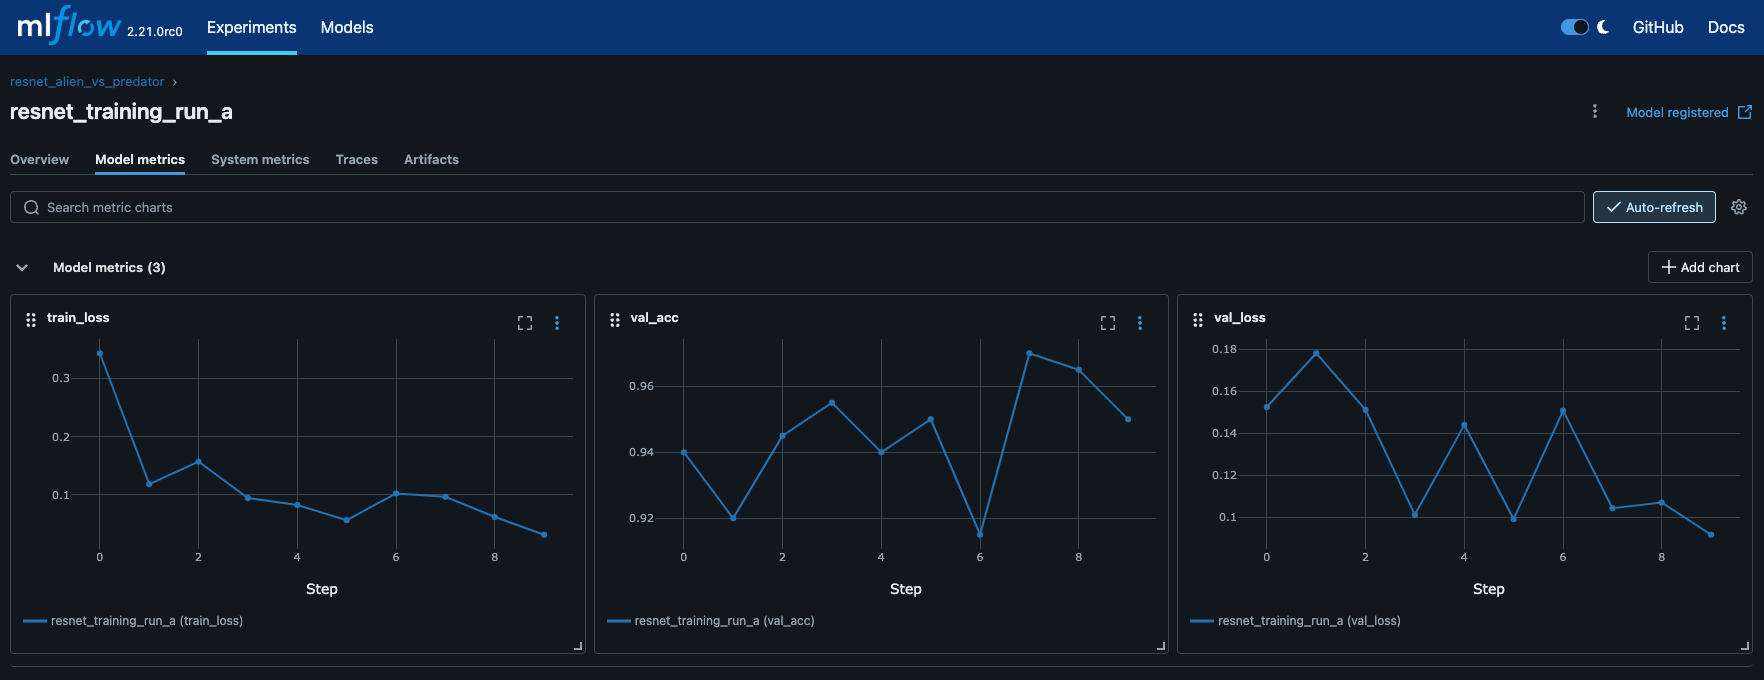